In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score

In [2]:
df = pd.read_csv('saki1.csv', error_bad_lines=False,sep=';')

In [3]:
df.head()

,Unnamed: 0,Auftragskonto,Buchungstag,Valutadatum,Buchungstext,Verwendungszweck,Beguenstigter/Zahlungspflichtiger,Kontonummer,BLZ,Betrag,Waehrung,label
0,0,89990201.0,28.07.2016,28.07.2016,Lohn / Gehalt,Gehalt Adorsys GmbH & Co. KG End-To-End-Ref.: ...,Adorsys GmbH & Co. KG,7807800780,25190001,2000.00,EUR,income
1,1,89990201.0,27.07.2016,27.07.2016,Miete,Byladem1Sbt De12773501123456789889 Miete Beuth...,Georg Tasche,DE31251900019123456780,VOHADE2HXXX,-670.00,EUR,living
2,2,89990201.0,21.07.2016,21.07.2016,Bargeld,"21.07/16.34Uhr Nuernberg All Eur 70,00 Geb.Eur...",Bargeld,9999900780,25190001,-70.00,EUR,private
3,3,89990201.0,20.07.2016,20.07.2016,Lebensmittel / Getraenke,2831 Edeka Neubauer Nuernb.//Nuernb 2016-07-20...,Kartenzahlung,9736000780,25190001,-73.21,EUR,standardOfLiving
4,4,89990201.0,18.07.2016,18.07.2016,Spontanausgabe,Amazon,neue Playstation,9988776655,25125100,-363,EUR,leisure


In [4]:
df['category_id'] = df['label'].factorize()[0]
category_id_df = df[['label', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'label']].values)
df

,Unnamed: 0,Auftragskonto,Buchungstag,Valutadatum,Buchungstext,Verwendungszweck,Beguenstigter/Zahlungspflichtiger,Kontonummer,BLZ,Betrag,Waehrung,label,category_id
0,0,89990201.0,28.07.2016,28.07.2016,Lohn / Gehalt,Gehalt Adorsys GmbH & Co. KG End-To-End-Ref.: ...,Adorsys GmbH & Co. KG,7807800780,25190001,2000.00,EUR,income,0
1,1,89990201.0,27.07.2016,27.07.2016,Miete,Byladem1Sbt De12773501123456789889 Miete Beuth...,Georg Tasche,DE31251900019123456780,VOHADE2HXXX,-670.00,EUR,living,1
2,2,89990201.0,21.07.2016,21.07.2016,Bargeld,"21.07/16.34Uhr Nuernberg All Eur 70,00 Geb.Eur...",Bargeld,9999900780,25190001,-70.00,EUR,private,2
3,3,89990201.0,20.07.2016,20.07.2016,Lebensmittel / Getraenke,2831 Edeka Neubauer Nuernb.//Nuernb 2016-07-20...,Kartenzahlung,9736000780,25190001,-73.21,EUR,standardOfLiving,3
4,4,89990201.0,18.07.2016,18.07.2016,Spontanausgabe,Amazon,neue Playstation,9988776655,25125100,-363,EUR,leisure,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,204,NaN,15.02.2016,15.02.2016,Mieteinnahmen,Mietzuschuss End-To-End-Ref.: Notprovided Kund...,Isabel Anna,DE31251900019736000780,VOHADE2HXXX,200.00,EUR,finance,5
205,205,NaN,02.02.2016,02.02.2016,Geldanlage,Ccbade31Xxx De71310108339900123456 Sparen End-...,Michael Koffer,DE69790800529736000780,DRESDEFF790,-300.00,EUR,finance,5
206,206,NaN,28.01.2016,28.01.2016,Lohn / Gehalt,Gehalt Adorsys GmbH & Co. KG End-To-End-Ref.: ...,Adorsys GmbH & Co. KG,7807800780,25190001,2000.00,EUR,income,0
207,207,NaN,28.01.2016,28.01.2016,Geldanlage,Ssknde77Xxx De41760501010012345675 Einmalspare...,Christina Jung,DE31251900019736333780,VOHADE2HXXX,-4000.00,EUR,finance,5


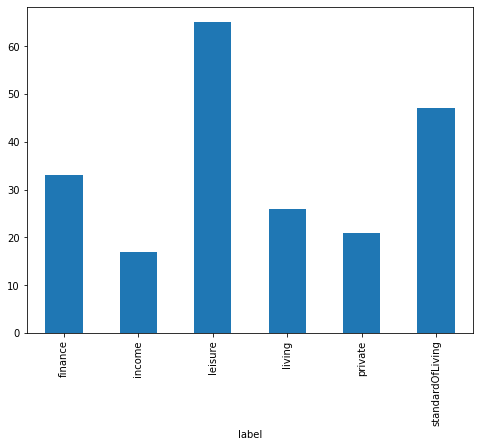

In [5]:
fig = plt.figure(figsize=(8,6))
df.groupby('label').Verwendungszweck.count().plot.bar(ylim=0)
plt.show()

In [6]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words=['english','german'])
features = tfidf.fit_transform(df.Verwendungszweck).toarray()
labels = df.category_id
features.shape

(209, 202)

In [7]:
gnb = GaussianNB()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.30, random_state=0)
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)


print(accuracy_score(y_test, y_pred))                                    #ACCURACY SCORE


print(precision_score(y_test, y_pred, average='weighted'))              #PRECISION SCORE


confusion_matrix(y_test, y_pred)                                        #CONFUSION MATRIX



0.9047619047619048
0.9372201872201872


array([[ 3,  0,  0,  0,  0,  0],
       [ 0,  5,  0,  1,  1,  0],
       [ 0,  0,  1,  0,  0,  0],
       [ 0,  0,  1, 15,  0,  0],
       [ 0,  1,  1,  0, 25,  0],
       [ 0,  0,  1,  0,  0,  8]], dtype=int64)